In [1]:
import os
from glob import glob
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix , classification_report

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
#讀檔案
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../skin/image','*','*'))}
imageid_path_dict

{'ISIC_0026784': '../skin/image/HAM10000_images_part_1/ISIC_0026784.jpg',
 'ISIC_0028971': '../skin/image/HAM10000_images_part_1/ISIC_0028971.jpg',
 'ISIC_0026948': '../skin/image/HAM10000_images_part_1/ISIC_0026948.jpg',
 'ISIC_0026790': '../skin/image/HAM10000_images_part_1/ISIC_0026790.jpg',
 'ISIC_0028965': '../skin/image/HAM10000_images_part_1/ISIC_0028965.jpg',
 'ISIC_0025299': '../skin/image/HAM10000_images_part_1/ISIC_0025299.jpg',
 'ISIC_0024839': '../skin/image/HAM10000_images_part_1/ISIC_0024839.jpg',
 'ISIC_0024811': '../skin/image/HAM10000_images_part_1/ISIC_0024811.jpg',
 'ISIC_0026960': '../skin/image/HAM10000_images_part_1/ISIC_0026960.jpg',
 'ISIC_0028795': '../skin/image/HAM10000_images_part_1/ISIC_0028795.jpg',
 'ISIC_0026974': '../skin/image/HAM10000_images_part_1/ISIC_0026974.jpg',
 'ISIC_0028781': '../skin/image/HAM10000_images_part_1/ISIC_0028781.jpg',
 'ISIC_0028959': '../skin/image/HAM10000_images_part_1/ISIC_0028959.jpg',
 'ISIC_0024805': '../skin/image/HAM100

In [4]:
df1=pd.read_csv("HAM10000_metadata.csv")
df1

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [5]:
df1['path']=df1['image_id'].map(imageid_path_dict.get)
df1.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0027...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0025...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0026...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0025...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../skin/image/HAM10000_images_part_2/ISIC_0031...


In [6]:
df1['image_pixel'] = df1['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
df1.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0027...,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0025...,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0026...,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0025...,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../skin/image/HAM10000_images_part_2/ISIC_0031...,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


In [7]:
label_mapping = {
    'akiec':0,
    'bcc':1,
    'bkl':2,
    'df':3,
    'nv':4,
    'vasc':5,
    'mel':6}


In [8]:
df1['label']=df1['dx'].map(label_mapping.get)
df1.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image_pixel,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0027...,"[[[191, 152, 192], [194, 154, 193], [196, 152,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0025...,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0026...,"[[[190, 136, 150], [199, 145, 161], [200, 141,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../skin/image/HAM10000_images_part_1/ISIC_0025...,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../skin/image/HAM10000_images_part_2/ISIC_0031...,"[[[155, 110, 135], [188, 139, 168], [210, 157,...",2


In [9]:
x=df1['image_pixel'].to_numpy()
x=np.stack(x,axis=0)
x

array([[[[191, 152, 192],
         [194, 154, 193],
         [196, 152, 184],
         ...,
         [195, 149, 159],
         [197, 155, 164],
         [194, 152, 161]],

        [[196, 161, 199],
         [200, 161, 199],
         [200, 158, 191],
         ...,
         [195, 150, 154],
         [197, 157, 165],
         [192, 151, 164]],

        [[198, 159, 198],
         [199, 158, 194],
         [201, 157, 190],
         ...,
         [197, 155, 161],
         [198, 159, 175],
         [194, 156, 177]],

        ...,

        [[192, 157, 192],
         [204, 172, 204],
         [206, 168, 196],
         ...,
         [189, 151, 177],
         [191, 157, 183],
         [193, 162, 196]],

        [[183, 150, 181],
         [199, 167, 194],
         [202, 164, 189],
         ...,
         [180, 136, 154],
         [188, 154, 176],
         [189, 158, 188]],

        [[170, 134, 163],
         [186, 148, 175],
         [196, 156, 178],
         ...,
         [176, 131, 146],
        

In [10]:
y=np.array(df1["label"])
y

array([2, 2, 2, ..., 0, 0, 6])

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df1['image_pixel'],df1['label'],test_size=0.2,random_state=999)

In [12]:
unique,counts=np.unique(y_train,return_counts=True)
dict(zip(unique,counts))

{0: 255, 1: 416, 2: 868, 3: 96, 4: 5379, 5: 101, 6: 897}

In [13]:
unique,counts=np.unique(y_test,return_counts=True)
dict(zip(unique,counts))

{0: 72, 1: 98, 2: 231, 3: 19, 4: 1326, 5: 41, 6: 216}

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.2,random_state=999)

In [15]:
unique,counts=np.unique(y_train,return_counts=True)
dict(zip(unique,counts))

{0: 206, 1: 335, 2: 698, 3: 74, 4: 4301, 5: 82, 6: 713}

In [16]:
unique,counts=np.unique(y_valid,return_counts=True)
dict(zip(unique,counts))

{0: 49, 1: 81, 2: 170, 3: 22, 4: 1078, 5: 19, 6: 184}

In [17]:
x_train

1410    [[[181, 139, 135], [186, 149, 153], [185, 148,...
7362    [[[197, 173, 201], [198, 173, 203], [199, 174,...
7869    [[[189, 184, 209], [183, 172, 188], [182, 169,...
8410    [[[215, 114, 135], [214, 101, 131], [224, 140,...
2139    [[[151, 97, 92], [153, 98, 93], [162, 111, 108...
                              ...                        
700     [[[177, 142, 181], [183, 148, 189], [188, 152,...
7491    [[[123, 99, 113], [131, 107, 122], [136, 112, ...
7592    [[[137, 90, 91], [151, 107, 107], [157, 118, 1...
1116    [[[182, 127, 127], [185, 131, 130], [187, 131,...
5244    [[[233, 138, 153], [234, 138, 152], [235, 139,...
Name: image_pixel, Length: 6409, dtype: object

In [18]:
#撈出pixel label
df2=pd.concat([x_train, y_train],axis=1)
df2

,image_pixel,label
1410,"[[[181, 139, 135], [186, 149, 153], [185, 148,...",6
7362,"[[[197, 173, 201], [198, 173, 203], [199, 174,...",4
7869,"[[[189, 184, 209], [183, 172, 188], [182, 169,...",4
8410,"[[[215, 114, 135], [214, 101, 131], [224, 140,...",4
2139,"[[[151, 97, 92], [153, 98, 93], [162, 111, 108...",6
...,...,...
700,"[[[177, 142, 181], [183, 148, 189], [188, 152,...",2
7491,"[[[123, 99, 113], [131, 107, 122], [136, 112, ...",4
7592,"[[[137, 90, 91], [151, 107, 107], [157, 118, 1...",4
1116,"[[[182, 127, 127], [185, 131, 130], [187, 131,...",3


In [19]:
#找出個別label 的 pixel
train_lab0=df2.loc[df2["label"]==0]
train_lab1=df2.loc[df2["label"]==1]
train_lab2=df2.loc[df2["label"]==2]
train_lab3=df2.loc[df2["label"]==3]
train_lab4=df2.loc[df2["label"]==4]
train_lab5=df2.loc[df2["label"]==5]
train_lab6=df2.loc[df2["label"]==6]

In [20]:
#將pixel變成array
lab0_pixel=train_lab0['image_pixel'].to_numpy()
lab0_pixel_array=np.stack(lab0_pixel,axis=0)

lab1_pixel=train_lab1['image_pixel'].to_numpy()
lab1_pixel_array=np.stack(lab1_pixel,axis=0)

lab2_pixel=train_lab2['image_pixel'].to_numpy()
lab2_pixel_array=np.stack(lab2_pixel,axis=0)

lab3_pixel=train_lab3['image_pixel'].to_numpy()
lab3_pixel_array=np.stack(lab3_pixel,axis=0)

lab4_pixel=train_lab4['image_pixel'].to_numpy()
lab4_pixel_array=np.stack(lab4_pixel,axis=0)

lab5_pixel=train_lab5['image_pixel'].to_numpy()
lab5_pixel_array=np.stack(lab5_pixel,axis=0)

lab6_pixel=train_lab6['image_pixel'].to_numpy()
lab6_pixel_array=np.stack(lab6_pixel,axis=0)

In [21]:

#Augmentating test Images and generating more images by performing a variety of image changes
#train_datagen = ImageDataGenerator( featurewise_center=False, 
#        samplewise_center=False,  
#        featurewise_std_normalization=False,  
#        samplewise_std_normalization=False, 
#        zca_whitening=False,  
#        rotation_range=10,  
#        zoom_range = 0.1,  
#       width_shift_range=0.12,  
#        height_shift_range=0.12,
#        horizontal_flip=True,  
#        vertical_flip=True)  

#train_datagen.fit(x_train)  

In [22]:
#對 label 012356 資料擴增至4000個到個別資料夾
#i=0
#for batch in train_datagen.flow(lab6_pixel_array,batch_size=200,save_to_dir="label6",save_prefix="cat",save_format="jpg"):
#    i+=1
#   if i>20:
#        break

In [23]:
#將擴增後的資料讀入 變成新的dataframe
imageid_path_dict_label0 = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../skin/label0','*'))}
a=[v for k,v in imageid_path_dict_label0.items()]
temp_df0=pd.DataFrame(a)
temp_df0['image_pixel'] = temp_df0[0].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
temp_df0['label']=0
temp_df0_1=temp_df0.drop(0,axis=1)

imageid_path_dict_label1= {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../skin/label1','*'))}
a=[v for k,v in imageid_path_dict_label1.items()]
temp_df1=pd.DataFrame(a)
temp_df1['image_pixel'] = temp_df1[0].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
temp_df1['label']=1
temp_df1_1=temp_df1.drop(0,axis=1)

imageid_path_dict_label2 = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../skin/label2','*'))}
a=[v for k,v in imageid_path_dict_label2.items()]
temp_df2=pd.DataFrame(a)
temp_df2['image_pixel'] = temp_df2[0].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
temp_df2['label']=2
temp_df2_1=temp_df2.drop(0,axis=1)

imageid_path_dict_label3 = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../skin/label3','*'))}
a=[v for k,v in imageid_path_dict_label3.items()]
temp_df3=pd.DataFrame(a)
temp_df3['image_pixel'] = temp_df3[0].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
temp_df3['label']=3
temp_df3_1=temp_df3.drop(0,axis=1)


imageid_path_dict_label5 = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../skin/label5','*'))}
a=[v for k,v in imageid_path_dict_label5.items()]
temp_df5=pd.DataFrame(a)
temp_df5['image_pixel'] = temp_df5[0].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
temp_df5['label']=5
temp_df5_1=temp_df5.drop(0,axis=1)


imageid_path_dict_label6= {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../skin/label6','*'))}
a=[v for k,v in imageid_path_dict_label6.items()]
temp_df6=pd.DataFrame(a)
temp_df6['image_pixel'] = temp_df6[0].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
temp_df6['label']=6
temp_df6_1=temp_df6.drop(0,axis=1)


In [24]:
#將擴增資料與原資料合併
train_lab0_aug=pd.concat([train_lab0,temp_df0_1],axis=0)
train_lab1_aug=pd.concat([train_lab1,temp_df1_1],axis=0)
train_lab2_aug=pd.concat([train_lab2,temp_df2_1],axis=0)
train_lab3_aug=pd.concat([train_lab3,temp_df3_1],axis=0)
train_lab5_aug=pd.concat([train_lab5,temp_df5_1],axis=0)
train_lab6_aug=pd.concat([train_lab6,temp_df6_1],axis=0)
train_lab4_aug=df2.loc[df2["label"]==4]

In [25]:
#將擴充資料與原資料和label4資料 合併成train
train_aug=pd.concat([train_lab0_aug
                     ,train_lab1_aug
                     ,train_lab2_aug
                     ,train_lab3_aug
                     ,train_lab4_aug
                     ,train_lab5_aug
                     ,train_lab6_aug],axis=0)

In [26]:
train_aug 

,image_pixel,label
9967,"[[[174, 127, 133], [181, 136, 139], [185, 138,...",0
9876,"[[[85, 50, 56], [133, 91, 86], [160, 115, 106]...",0
9870,"[[[175, 127, 114], [178, 129, 116], [182, 131,...",0
9739,"[[[211, 178, 176], [215, 183, 183], [217, 185,...",0
9978,"[[[129, 93, 95], [193, 147, 152], [217, 182, 1...",0
...,...,...
3760,"[[[188, 119, 114], [195, 126, 121], [202, 132,...",6
3761,"[[[244, 165, 184], [245, 166, 185], [245, 170,...",6
3762,"[[[62, 28, 52], [67, 32, 54], [63, 28, 50], [7...",6
3763,"[[[142, 105, 146], [143, 106, 147], [155, 118,...",6


In [27]:
unique,counts=np.unique(train_aug['label'],return_counts=True)
dict(zip(unique,counts))

{0: 4518, 1: 4687, 2: 4388, 3: 4576, 4: 4301, 5: 4256, 6: 4478}

In [28]:
#將 tain 資料變成array
x_train_array=train_aug['image_pixel'].to_numpy()
x_valid_array=x_valid.to_numpy()
x_test_array=x_test.to_numpy()

x_train_array_stack=np.stack(x_train_array,axis=0)
x_valid_array_stack=np.stack(x_valid_array,axis=0)
x_test_array_stack=np.stack(x_test_array,axis=0)

#normalize
x_train_nor=x_train_array_stack/255
x_valid_nor=x_valid_array_stack/255
x_test_nor=x_test_array_stack/255

In [29]:
#將label變成array
y_train_label=np.array(train_aug['label'])
y_valid_label=np.array(y_valid)
y_test_label=np.array(y_test)

In [30]:
from tensorflow.keras.utils import to_categorical

In [31]:
#將label變成 one hot encoding
y_train_oh=to_categorical(y_train_label,7)
y_valid_oh=to_categorical(y_valid_label,7)
y_test_oh=to_categorical(y_test_label,7)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D,BatchNormalization,Dropout,Activation

In [46]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation = 'relu', padding = 'same',input_shape = (32,32,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(7,activation = 'softmax'))
model.summary()




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 14343     
Total params: 19,431
Trainable params: 19,431
Non-trainable params: 0
__________________________________________________

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.000001)

In [48]:
opt=ks.optimizers.Adam(lr=0.001)

model.compile(loss = 'categorical_crossentropy', optimizer =opt, metrics = ['accuracy'])

In [49]:
ks.regularizers.l1(0.01)

In [38]:
x_train_nor.shape

(31204, 32, 32, 3)

In [39]:
y_train_oh.shape

(31204, 7)

In [50]:
history = model.fit(x_train_nor,y_train_oh,batch_size=64
                        ,epochs =50,validation_data =(x_valid_nor,y_valid_oh),shuffle=True)
                    

Train on 31204 samples, validate on 1603 samples
Epoch 1/50
31204/31204 [==============================] - 45s 1ms/sample - loss: 1.5525 - accuracy: 0.3950 - val_loss: 1.1529 - val_accuracy: 0.6132
Epoch 2/50
31204/31204 [==============================] - 44s 1ms/sample - loss: 1.2109 - accuracy: 0.5385 - val_loss: 1.0937 - val_accuracy: 0.6076
Epoch 3/50
31204/31204 [==============================] - 44s 1ms/sample - loss: 1.1219 - accuracy: 0.5744 - val_loss: 0.9225 - val_accuracy: 0.6843
Epoch 4/50
31204/31204 [==============================] - 45s 1ms/sample - loss: 1.0569 - accuracy: 0.5990 - val_loss: 0.9746 - val_accuracy: 0.6519
Epoch 5/50
31204/31204 [==============================] - 44s 1ms/sample - loss: 1.0011 - accuracy: 0.6226 - val_loss: 0.9874 - val_accuracy: 0.6538
Epoch 6/50
31204/31204 [==============================] - 44s 1ms/sample - loss: 0.9618 - accuracy: 0.6324 - val_loss: 0.9014 - val_accuracy: 0.6806
Epoch 7/50
31204/31204 [==============================] -

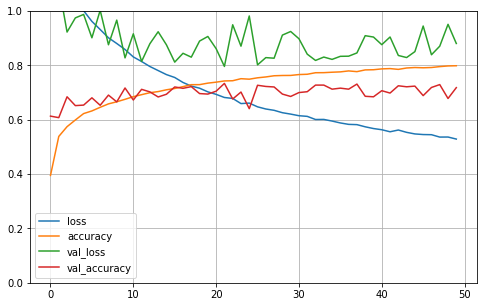

In [57]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [58]:
a=model.predict(x_test_nor)
predictionst=np.argmax(a,axis=1)
predictionst


array([4, 1, 2, ..., 6, 2, 4])

In [53]:
y_test_label

array([4, 5, 6, ..., 6, 6, 4])

In [59]:
accuracy = np.mean(predictionst == y_test_label)
print("Prediction Accuracy: %.2f%%" % (accuracy * 100))

Prediction Accuracy: 70.59%


In [60]:
pd.crosstab(y_test, predictionst, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,19,15,16,1,15,0,6
1,17,47,4,9,15,1,5
2,18,10,101,1,80,0,21
3,2,7,3,2,4,0,1
4,11,21,64,14,1152,4,60
5,0,8,1,0,3,28,1
6,9,9,51,1,77,4,65


In [56]:
print(classification_report(y_test_label , predictionst ))

              precision    recall  f1-score   support

           0       0.25      0.26      0.26        72
           1       0.40      0.48      0.44        98
           2       0.42      0.44      0.43       231
           3       0.07      0.11      0.09        19
           4       0.86      0.87      0.86      1326
           5       0.76      0.68      0.72        41
           6       0.41      0.30      0.35       216

    accuracy                           0.71      2003
   macro avg       0.45      0.45      0.45      2003
weighted avg       0.70      0.71      0.70      2003



Text(69.0, 0.5, 'Actual')

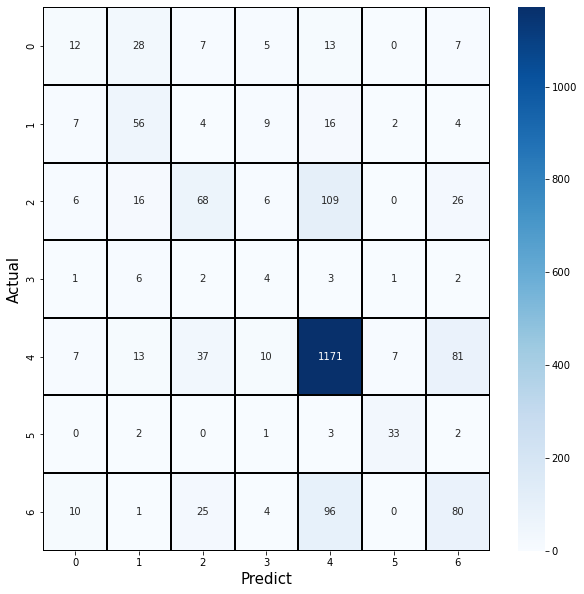

In [244]:
cm = confusion_matrix(y_test_label ,predictionst)
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues",linecolor = 'black' , linewidth =2, annot = True, fmt='')
plt.xlabel('Predict',fontsize = 15)
plt.ylabel('Actual', fontsize = 15)